In [146]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

In [147]:
# Parameters
num_classes = 7
batch_size = 68
input_shape = (96, 96, 3)
epochs_initial = 30
epochs_finetune = 20

# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/train"),
    image_size=input_shape[:2],
    batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/val"),
    image_size=input_shape[:2],
    batch_size=batch_size
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/test"),
    image_size=input_shape[:2],
    batch_size=batch_size
)

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True) / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

Found 2445 files belonging to 7 classes.
Found 322 files belonging to 7 classes.
Found 314 files belonging to 7 classes.


In [148]:
# Compute class weights
y_train = []
for _, labels in train_dataset:
    y_train.append(labels.numpy())
y_train = np.concatenate(y_train, axis=0)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


In [149]:
# Build Model
conv_base = keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
conv_base.trainable = False  # Freeze at first

inputs = keras.Input(shape=input_shape)
x = conv_base(inputs)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint(filepath="emotions_MobileNet.keras", save_best_only=True, monitor="val_loss")
]

In [150]:
# Initial Training (only dense layers)
start_time = time.time()

history_initial = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_initial,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=0
)

training_time_initial = time.time() - start_time


In [151]:
# Fine-tuning: Unfreeze top layers
conv_base.trainable = True

for layer in conv_base.layers[:-30]:
    layer.trainable = False  # Freeze most layers, fine-tune last ~30

# Re-compile with a small learning rate
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)


In [152]:
# Fine-tuning Training
start_time = time.time()

history_finetune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_finetune,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

training_time_finetune = time.time() - start_time

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy after fine-tuning: {test_acc:.3f}")

# Save results
np.savez("emotions_MobileNet.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time_initial + training_time_finetune,
         history_initial=history_initial.history,
         history_finetune=history_finetune.history)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.2039 - loss: 2.5633 - val_accuracy: 0.3665 - val_loss: 1.5926
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.1936 - loss: 2.4569 - val_accuracy: 0.3602 - val_loss: 1.5910
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.2143 - loss: 2.3375 - val_accuracy: 0.3602 - val_loss: 1.5932
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.2364 - loss: 2.1549 - val_accuracy: 0.3571 - val_loss: 1.5973
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.2261 - loss: 2.2659 - val_accuracy: 0.3634 - val_loss: 1.6005
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.2484 - loss: 2.2069 - val_accuracy: 0.3758 - val_loss: 1.6028
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.2679 - loss: 1.9898 - val_accuracy: 0.3758 - val_loss: 1.6082
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.2652 - loss: 2.0533 - val_accu

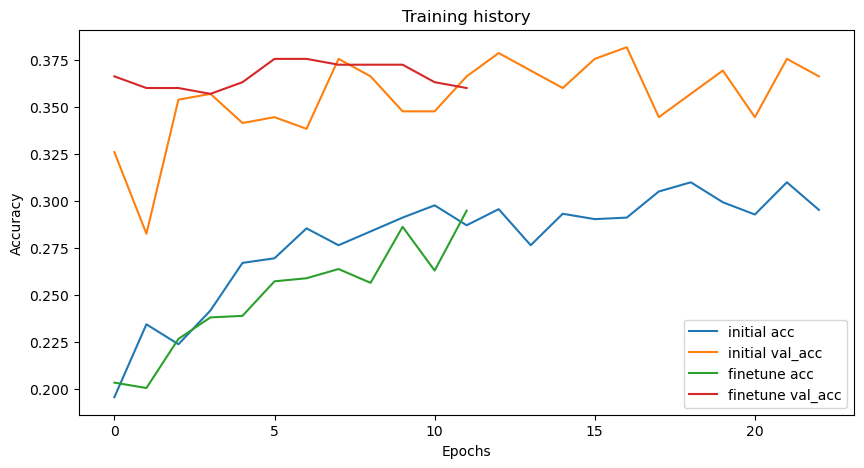

In [153]:
# Plot training history
def plot_history(histories, title="Training history"):
    plt.figure(figsize=(10, 5))

    for name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{name} acc')
        plt.plot(history['val_accuracy'], label=f'{name} val_acc')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_history({"initial": history_initial.history, "finetune": history_finetune.history})

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


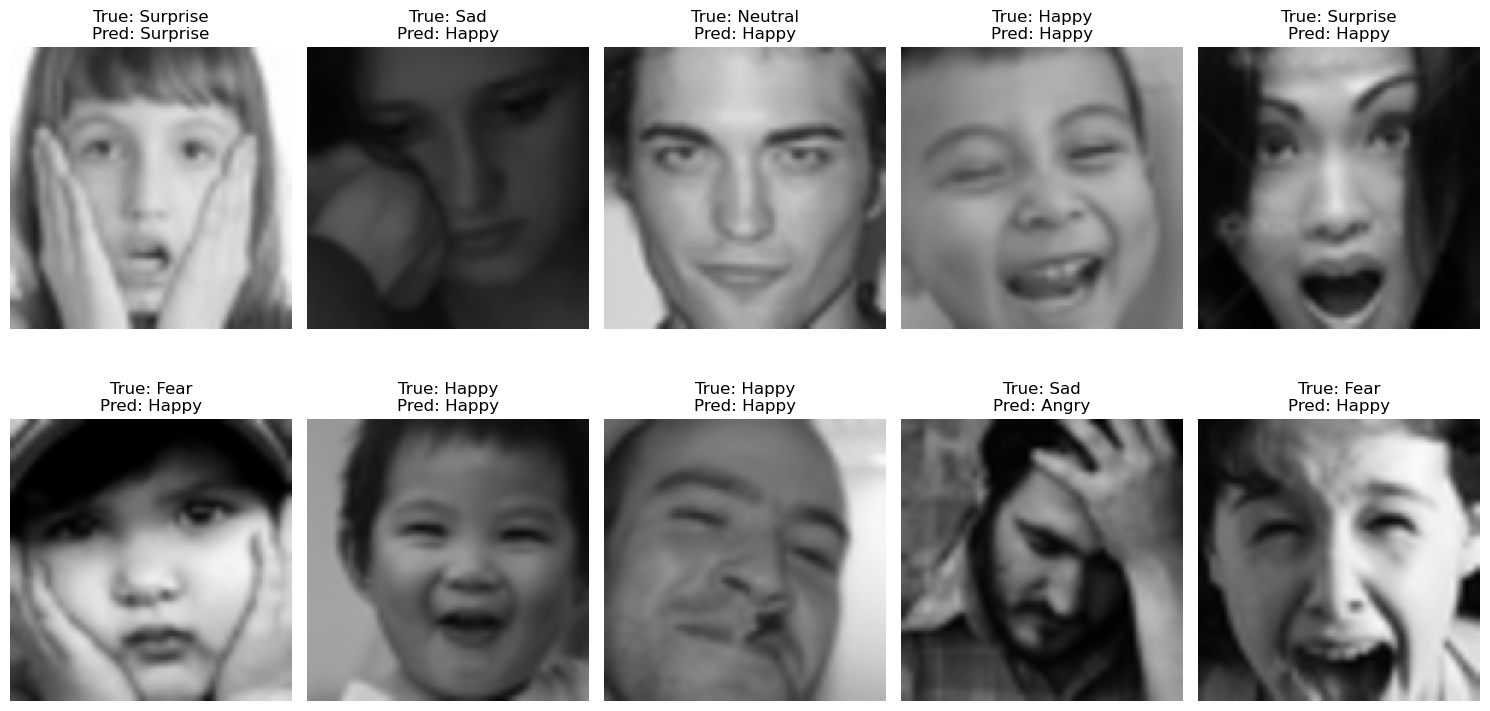

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Get a few test images and their true labels
x_test = []
y_test = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Make predictions
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Define emotion labels
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Visualize a few test images with true and predicted labels
def visualize_predictions(start=0, num_images=10):
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(2, 5, i+1)  # 2 rows, 5 images per row
        img = x_test[start + i]
        img = np.clip(img, 0.0, 1.0)  # Ensure values are between 0 and 1
        plt.imshow(img)  # Display the image
        plt.axis('off')

        true_label = class_names[y_test[start + i]]  # True label
        pred_label = class_names[y_pred_labels[start + i]]  # Predicted label

        plt.title(f"True: {true_label}\nPred: {pred_label}")

    plt.tight_layout()
    plt.show()

# Visualize first 10 images from the test set
visualize_predictions(start=0, num_images=10)


In [155]:
# Calculate class-wise accuracies
class_accuracies = {}
for i, class_name in enumerate(class_names):
    true_class_indices = (y_test == i)
    correct_predictions = (y_pred_labels[true_class_indices] == i).sum()
    total_samples = true_class_indices.sum()
    class_accuracies[class_name] = correct_predictions / total_samples

# Display class-wise accuracies
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class '{class_name}': {accuracy:.2%}")


Accuracy for class 'Angry': 11.43%
Accuracy for class 'Disgust': 20.00%
Accuracy for class 'Fear': 9.52%
Accuracy for class 'Happy': 81.93%
Accuracy for class 'Sad': 31.48%
Accuracy for class 'Surprise': 44.12%
Accuracy for class 'Neutral': 24.59%


In [158]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
class_f1_scores = {}
for i, class_name in enumerate(class_names):
    true_class_indices = (y_test == i)
    pred_class_indices = (y_pred_labels == i)

    precision = precision_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)

    class_f1_scores[class_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Print header
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 40)

# Each class's scores
for class_name, scores in class_f1_scores.items():
    print(f"{class_name:<10} {scores['precision']:<10.2f} {scores['recall']:<10.2f} {scores['f1_score']:<10.2f}")

Class      Precision  Recall     F1 Score  
----------------------------------------
Angry      0.22       0.11       0.15      
Disgust    0.14       0.20       0.17      
Fear       0.24       0.10       0.14      
Happy      0.41       0.82       0.54      
Sad        0.47       0.31       0.38      
Surprise   0.43       0.44       0.43      
Neutral    0.44       0.25       0.32      
